**Nithun Selva and Saad Khan**

Spring 2025

CS 444: Deep Learning

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=7)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

2025-04-04 12:49:26.777971: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-04 12:49:26.788053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743785366.799146   31402 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743785366.802269   31402 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 12:49:26.813927: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Project 2 | Branch Neural Networks

This project focuses on key innovations in the CNN architecture that go beyond AlexNet/VGG networks and bring us to "modern" CNNs that often have one or more **branches**. Our goal remains achieving high classification accuracy on image datasets. In addition to working with CIFAR-10, this week you will begin working with the CIFAR-100 dataset, which has the same number of samples as CIFAR-10, but has 100 classes.

#### Week 1: Inception

This notebook focuses on building and exploring the influential Inception network that won the 2014 ImageNet challenge*.

**The InceptionNet that we build here has mostly the same architecture as the one that won the competition, but the hyperparameters and size are scaled down to make the training time and resources more reasonable. We are also using batch normalization throughout, which was not originally used.* 

## Task 1: Inception operations

Before building out the network, let's explore the core new computational concepts that Inception introduces on their own without the complexity of the neural network.

In [1]:
def show_image(img, title):
    '''This function is provided.'''
    plt.imshow(img)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

### 1a. Load in, view, and preprocess Miller and Allen Island test images

In the cells below:
1. Load in `miller_quad.jpg` and `allen_island.jpg`.
2. Preprocess them: normalize them *globally* so that the minimum and maximum possible feature values are 0.0 and 1.0.
3. Convert the images to TensorFlow tensors.
4. Visualize/show the two preprocessed images. They should look like regular color images.
5. Print out the shapes. They should both be `(600, 600, 3)`.

Miller image size: (600, 600, 3)


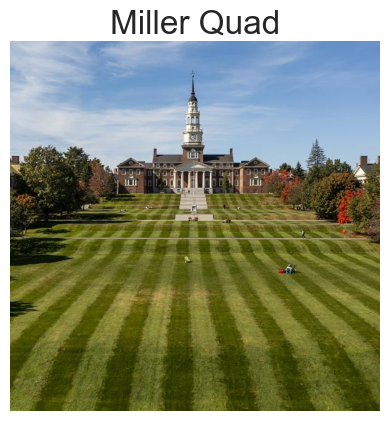

In [4]:
miller_img = Image.open('data/miller_quad.jpg')
miller_np = np.array(miller_img).astype(np.float32) / 255.0
miller_tf = tf.convert_to_tensor(miller_np)

print('Miller image size:', miller_tf.shape)

show_image(miller_tf, 'Miller Quad')

Allen image size: (600, 600, 3)


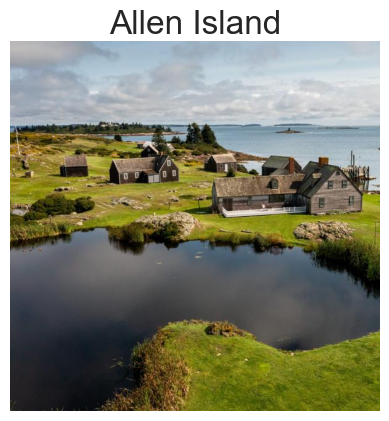

In [5]:
allen_img = Image.open('data/allen_island.jpg')
allen_np = np.array(allen_img).astype(np.float32) / 255.0
allen_tf = tf.convert_to_tensor(allen_np)

print('Allen image size:', allen_tf.shape)

show_image(allen_tf, 'Allen Island')

### 1b. 1x1 convolution

The 1x1 convolution operation is widely used throughout InceptionNet. While it can be viewed as just a special case as regular convolution (i.e. just plug and chug with `tf.nn.conv2d` and you will get the correct answer), it offers a different interpretation than 2D convolution. We will explore this new perspective using image processing.

Implement the function `conv_1x1` in `inception_ops.py` then fill in the code below to call it on the Miller image. 

In [8]:
from inception_ops import conv_1x1

The following cell should use 1x1 convolution to convert the colored Miller image into grayscale, using a filter that [weights colors in proportion to which the human eye is sensitive to red, green, and blue wavelengths](https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale). 

The shape of miller_filtered is (600, 600, 1) and min/max is 0.0000/0.9977
The shape should be (600, 600, 1) and the min/max should be 0.0000/0.9977


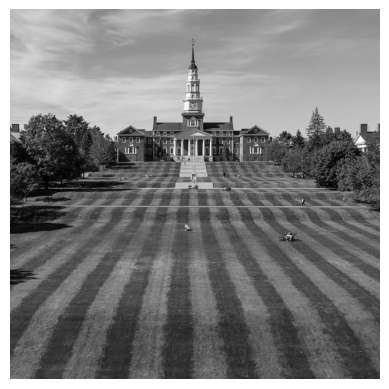

In [10]:
# One filter/neuron with 3 input color chans
gray_filter = tf.constant([[0.299], [0.587], [0.114]])

miller_filtered = conv_1x1(miller_tf, gray_filter)

print(f'The shape of miller_filtered is {miller_filtered.shape} and min/max is {tf.reduce_min(miller_filtered):.4f}/{tf.reduce_max(miller_filtered):.4f}')
print('The shape should be (600, 600, 1) and the min/max should be 0.0000/0.9977')
plt.imshow(miller_filtered, cmap='gray')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.show()

The following cell should use 1x1 convolution to apply a [Sepia filter](https://stackoverflow.com/questions/1061093/how-is-a-sepia-tone-created) to the Miller image.

The shape of miller_filtered is (600, 600, 3) and min/max is 0.0000/1.0000
The shape should be (600, 600, 3) and the min/max should be 0.0000/1.0000


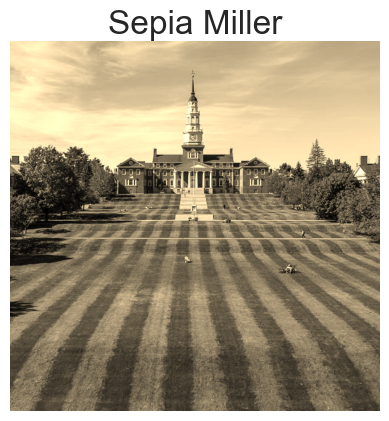

In [11]:
# 3 filters/neurons with 3 input color chans
sepia_filter = tf.constant([[0.393, 0.349, 0.272],
                            [0.769, 0.686, 0.534],
                            [0.189, 0.168, 0.131]])

miller_filtered = conv_1x1(miller_tf, sepia_filter)

miller_filtered  = tf.clip_by_value(miller_filtered, clip_value_min=0, clip_value_max=1)

print(f'The shape of miller_filtered is {miller_filtered.shape} and min/max is {tf.reduce_min(miller_filtered):.4f}/{tf.reduce_max(miller_filtered):.4f}')
print('The shape should be (600, 600, 3) and the min/max should be 0.0000/1.0000')
show_image(miller_filtered, 'Sepia Miller')

### 1c. 1x1 convolution (batch version)

A key limitation of `conv_1x1` is that it only processes a single image input at a time. For this to be useful for neural networks it should be capable of processing a batch of images at a time.

Address this by implementing the function `conv_1x1_batch` in `inception_ops.py` that adds mini-batch (*and stride*) support. Afterward, fill in the code below to apply the Sepia filter to both the Miller and Allen Island images.

In [12]:
from inception_ops import conv_1x1_batch

The mean of the mini-batch is 0.5160 and should be 0.5160.
The shape of miller_filtered is (2, 600, 600, 3) and should be (2, 600, 600, 3)


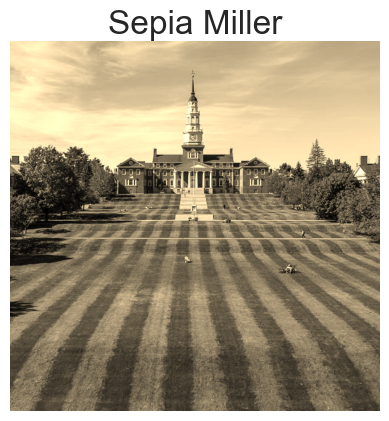

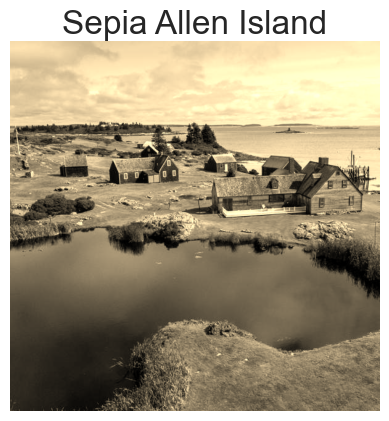

In [14]:
# Combine the two images into a mini-batch
imgs = tf.stack([miller_tf, allen_tf])

imgs_filtered = conv_1x1_batch(imgs, sepia_filter)

print(f'The mean of the mini-batch is {tf.reduce_mean(imgs_filtered):.4f} and should be 0.5160.')

imgs_filtered  = tf.clip_by_value(imgs_filtered, clip_value_min=0, clip_value_max=1)

print(f'The shape of miller_filtered is {imgs_filtered.shape} and should be (2, 600, 600, 3)')
show_image(imgs_filtered[0], 'Sepia Miller')
show_image(imgs_filtered[1], 'Sepia Allen Island')

Below, perform the same test, but use a stride of 8. If everything is working as expected, the output images should look similar to how they do above, but much blockier/pixelated.

The mean of the mini-batch is 0.5192 and should be 0.5192.
The shape of miller_filtered is (2, 75, 75, 3) and should be (2, 75, 75, 3)


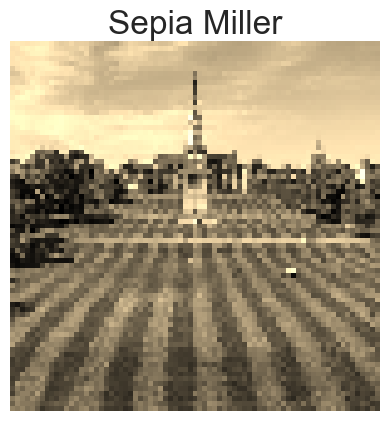

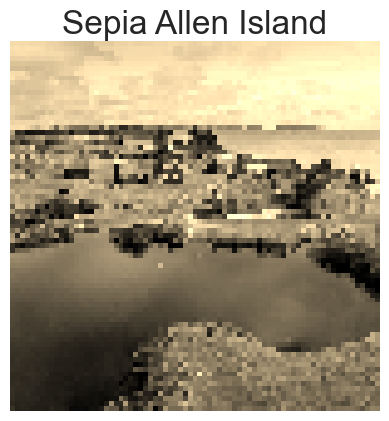

In [15]:
# TODO: Call conv_1x1 on both images
imgs_filtered = conv_1x1_batch(imgs, sepia_filter, strides=8)

print(f'The mean of the mini-batch is {tf.reduce_mean(imgs_filtered):.4f} and should be 0.5192.')

imgs_filtered  = tf.clip_by_value(imgs_filtered, clip_value_min=0, clip_value_max=1)

print(f'The shape of miller_filtered is {imgs_filtered.shape} and should be (2, 75, 75, 3)')
show_image(imgs_filtered[0], 'Sepia Miller')
show_image(imgs_filtered[1], 'Sepia Allen Island')

# Task 2: Build and test the Inception Block

With 1x1 convolution implemented, let's build Inception Net! We will work our way up the neural network hierarchy — start by building new layers and blocks then assembling them into Inception Net.

### 2a. Copy files from Project 1

Copy over your deep learning library from Project 1: `datasets.py`, `tf_util.py`, `layers.py`, `block.py`, `network.py`.

This will allow you to reuse all your training/layer/network code that you developed in Project 1! You only need to create components that are unique and new to Inception Net.

### 2b. Implement `Conv2D1x1` layer

This is the network layer that performs 1x1 convolution. The class inherits from `Conv2D` and is located in `inception_layers.py`.

In [18]:
from inception_layers import Conv2D1x1

[autoreload of inception_layers failed: Traceback (most recent call last):
  File "/opt/homebrew/anaconda3/envs/tfgpu/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/opt/homebrew/anaconda3/envs/tfgpu/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/homebrew/anaconda3/envs/tfgpu/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/homebrew/anaconda3/envs/tfgpu/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/opt/homebrew/anaconda3/envs/tfgpu/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/opt/homebrew/anaconda3/envs/tfgpu/lib/python3.10/site-packages/IPython/extensions/autoreload.py", 

#### Test: `Conv2D1x1` layer

(1/3) Testing weights and bias

In [20]:
tf.random.set_seed(0)
conv = Conv2D1x1('Test1x1', 4, do_batch_norm=False)
conv(tf.ones([1, 4, 4, 3]))
print(f'Your weights are\n{conv.get_wts().numpy()}')
print('and they should be:')
print('''[[ 1.2337776  0.3453145 -0.3426796 -0.8459209]
 [-1.0098659  0.3839764 -0.0114104  0.9706988]
 [ 0.4919664  0.4896621 -0.5762113 -0.3535231]]''')
print(f'Your biases are\n{conv.get_b().numpy()}')
print('and they should be:')
print('''[0. 0. 0. 0.]''')

Your weights are
[[ 1.2337776  0.3453145 -0.3426796 -0.8459209]
 [-1.0098659  0.3839764 -0.0114104  0.9706988]
 [ 0.4919664  0.4896621 -0.5762113 -0.3535231]]
and they should be:
[[ 1.2337776  0.3453145 -0.3426796 -0.8459209]
 [-1.0098659  0.3839764 -0.0114104  0.9706988]
 [ 0.4919664  0.4896621 -0.5762113 -0.3535231]]
Your biases are
[0. 0. 0. 0.]
and they should be:
[0. 0. 0. 0.]


(2/3) Testing activation and stride

In [21]:
tf.random.set_seed(0)
conv = Conv2D1x1('Test1x1', 4, strides=2)
tf.random.set_seed(1)
test_net_acts = conv(tf.random.uniform([2, 4, 4, 3]))
print(test_net_acts.numpy())
print(f'Your net_acts are\n{test_net_acts.numpy()}')
print('and they should be:')
print('''[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        0.       ]
   [0.3837539 0.        0.        0.038144 ]]

  [[0.        0.        0.        0.       ]
   [0.3536301 0.        0.        0.5435652]]]]''')

[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        0.       ]
   [0.3837539 0.        0.        0.038144 ]]

  [[0.        0.        0.        0.       ]
   [0.3536301 0.        0.        0.5435652]]]]
Your net_acts are
[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        0.       ]
   [0.3837539 0.        0.        0.038144 ]]

  [[0.        0.        0.        0.       ]
   [0.3536301 0.        0.        0.5435652]]]]
and they should be:
[[[[0.        0.        0.        0.       ]
   [0.        0.        0.        0.       ]]

  [[0.1286802 0.        0.        0.       ]
   [0.1233867 0.        0.        0.       ]]]


 [[[0.        0.        0.        

(3/3) Testing batch norm

In [22]:
tf.random.set_seed(0)
conv = Conv2D1x1('Test1x1', 5, strides=2)
conv(tf.ones([1, 4, 4, 3]))
conv.init_batchnorm_params()

conv.set_mode(True)

tf.random.set_seed(1)
for i in range(3):
    test_net_acts = conv(tf.random.uniform([2, 4, 4, 3]))
print(f'Your net_acts after 3 training steps are\n{test_net_acts.numpy()}')
print('and they should be:')
print('''[[[[1.0821913 0.7829832 0.1566384 0.        0.       ]
   [0.        0.        0.9201921 1.5349929 1.4050572]]

  [[0.        0.3684795 0.        1.1567515 1.2164567]
   [0.2499718 0.        1.9366031 0.        0.       ]]]


 [[[0.        0.200867  0.        0.        0.0255171]
   [0.        0.        0.0641299 0.271286  0.2673296]]

  [[1.0891017 1.5742371 0.        0.1243966 0.272232 ]
   [0.844538  0.4010135 0.        0.        0.       ]]]]''')

conv.set_mode(False)

test_net_acts = conv(tf.random.uniform([2, 4, 4, 3]))
print(f'Your net_acts after transitioning to in predict mode \n{test_net_acts.numpy()}')
print('and they should be:')
print('''[[[[0.0776796 0.        0.4667156 0.        0.       ]
   [0.4479264 0.0159945 0.6306992 0.        0.       ]]

  [[0.0817579 0.        0.7232838 0.        0.       ]
   [0.0959485 0.        0.2694484 0.        0.       ]]]


 [[[0.5344409 0.0541097 0.706812  0.2156344 0.1787143]
   [1.0073555 0.237892  0.        0.        0.       ]]

  [[0.2575162 0.        1.3112392 0.        0.       ]
   [0.9776454 0.043461  0.7792924 0.        0.       ]]]]''')

Your net_acts after 3 training steps are
[[[[1.0821913 0.7829832 0.1566384 0.        0.       ]
   [0.        0.        0.9201921 1.5349929 1.4050572]]

  [[0.        0.3684795 0.        1.1567515 1.2164567]
   [0.2499718 0.        1.9366031 0.        0.       ]]]


 [[[0.        0.200867  0.        0.        0.0255171]
   [0.        0.        0.0641299 0.271286  0.2673296]]

  [[1.0891017 1.5742371 0.        0.1243966 0.272232 ]
   [0.844538  0.4010135 0.        0.        0.       ]]]]
and they should be:
[[[[1.0821913 0.7829832 0.1566384 0.        0.       ]
   [0.        0.        0.9201921 1.5349929 1.4050572]]

  [[0.        0.3684795 0.        1.1567515 1.2164567]
   [0.2499718 0.        1.9366031 0.        0.       ]]]


 [[[0.        0.200867  0.        0.        0.0255171]
   [0.        0.        0.0641299 0.271286  0.2673296]]

  [[1.0891017 1.5742371 0.        0.1243966 0.272232 ]
   [0.844538  0.4010135 0.        0.        0.       ]]]]
Your net_acts after transitioning to 

### 2c. Implement the `InceptionBlock` class 

This is located in `inception_block.py`.

The Inception Block is the fundamental computational unit of Inception Net. Here is a refresher on its 4 branch structure:

**Branch 1:** 1x1 convolution.

**Branch 2:** 1x1 convolution → 3x3 2D convolution

**Branch 3:** 1x1 convolution → 5x5 2D convolution

**Branch 4:** 3x3 max pooling → 1x1 convolution

The activations are concatenated together along the neuron dimension to form the output of the block (*i.e. think of the neurons at the end of each branch being lined up next to each other*).

In [23]:
from layers import Conv2D
from inception_block import InceptionBlock

#### Test: `InceptionBlock`

In [24]:
rng = tf.random.Generator.from_seed(0)
test_imgs = rng.uniform(shape=(1, 8, 8, 3))

tf.random.set_seed(1)
in_block = InceptionBlock('testblock', 2, (3, 4), (6, 5), 7, prev_layer_or_block=None)
test_net_acts = in_block(test_imgs)
print(in_block)
print(f'Shape of netActs are: {test_net_acts.shape}')
print(f'Sum of netActs are: {tf.reduce_sum(tf.abs(test_net_acts)).numpy():.1f}')

testblock:
	Conv2D1x1 layer output(testblock/branch4_1_conv1x1) shape: [1, 8, 8, 7]
	MaxPool2D layer output(testblock/branch4_0_maxpool3x3) shape: [1, 8, 8, 3]
	Conv2D layer output(testblock/branch3_1_conv5x5) shape: [1, 8, 8, 5]
	Conv2D1x1 layer output(testblock/branch3_0_conv1x1) shape: [1, 8, 8, 6]
	Conv2D layer output(testblock/branch2_1_conv3x3) shape: [1, 8, 8, 4]
	Conv2D1x1 layer output(testblock/branch2_0_conv1x1) shape: [1, 8, 8, 3]
	Conv2D1x1 layer output(testblock/branch1_0_conv1x1) shape: [1, 8, 8, 2]
Shape of netActs are: (1, 8, 8, 18)
Sum of netActs are: 358.5


The above cell should print:

```
testblock:
	Conv2D1x1 layer output(testblock/branch4_1_conv1x1) shape: [1, 8, 8, 7]
	MaxPool2D layer output(testblock/branch4_0_maxpool3x3) shape: [1, 8, 8, 3]
	Conv2D layer output(testblock/branch3_1_conv5x5) shape: [1, 8, 8, 5]
	Conv2D1x1 layer output(testblock/branch3_0_conv1x1) shape: [1, 8, 8, 6]
	Conv2D layer output(testblock/branch2_1_conv3x3) shape: [1, 8, 8, 4]
	Conv2D1x1 layer output(testblock/branch2_0_conv1x1) shape: [1, 8, 8, 3]
	Conv2D1x1 layer output(testblock/branch1_0_conv1x1) shape: [1, 8, 8, 2]
Shape of netActs are: (1, 8, 8, 18)
Sum of netActs are: 358.5
```

In [25]:
rng = tf.random.Generator.from_seed(0)
test_imgs = rng.uniform(shape=(5, 16, 16, 3))

tf.random.set_seed(1)
conv_blah = Conv2D('convblaaa', 12, (3, 3), wt_init='he')
in_block = InceptionBlock('testblock', 5, (6, 7), (8, 9), 2,
                          prev_layer_or_block=conv_blah)
test_net_acts = in_block(conv_blah(test_imgs))
print(f'Shape of netActs are: {test_net_acts.shape} and should be (5, 16, 16, 23).')
print(f'Sum of abs netActs is: {tf.reduce_sum(tf.abs(test_net_acts)).numpy():.1f} and should be 6726.1.')

Shape of netActs are: (5, 16, 16, 23) and should be (5, 16, 16, 23).
Sum of abs netActs is: 6726.1 and should be 6726.1.


## Task 3: 2D Global Average Pooling

With the exception of the output layer, Inception does away with the large dense hidden layers. In its place, it uses 2D averaging pooling, a new type of net input operation.

### 3a. 2D Global Average Pooling

Implement `global_avg_pooling_2d` in `inception_ops.py` then test it using the **luminance staircase patterns** below.

In [26]:
from inception_ops import global_avg_pooling_2d

Run the following cell to create and visualize some other test luminance staircase inputs.

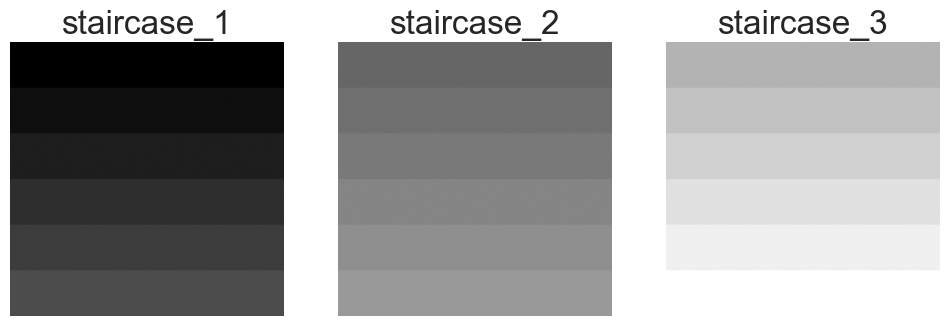

In [27]:
dark_staircase = np.expand_dims(np.repeat(np.linspace(0, 0.3, 6), 100), axis=1)
dark_staircase = np.tile(dark_staircase, reps=(1, 600))
mid_staircase = np.expand_dims(np.repeat(np.linspace(0.4, 0.6, 6), 100), axis=1)
mid_staircase = np.tile(mid_staircase, reps=(1, 600))
light_staircase = np.expand_dims(np.repeat(np.linspace(0.7, 1.0, 6), 100), axis=1)
light_staircase = np.tile(light_staircase, reps=(1, 600))
staircases_tf = tf.expand_dims(tf.stack([dark_staircase, mid_staircase, light_staircase]), axis=-1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

axes[0].imshow(dark_staircase, vmin=0, vmax=1, cmap='gray')
axes[1].imshow(mid_staircase, vmin=0, vmax=1, cmap='gray')
axes[2].imshow(light_staircase, vmin=0, vmax=1, cmap='gray')
axes[0].set_title('staircase_1')
axes[1].set_title('staircase_2')
axes[2].set_title('staircase_3')

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

In [28]:
avg_pool_result = global_avg_pooling_2d(staircases_tf)

print(avg_pool_result.numpy())

[[0.15]
 [0.5 ]
 [0.85]]


### 3b. Questions

**Question 1:** Interpret what the 3 outputs means in the context of the input images.

**Answer 1:** Here, each staircase image is a 600x600 image of luminance values. The 2D global average pooling operation takes the average of all the pixel values in the image and returns a single value per channel (here 1 for grayscale). So, the output is a single value that represents the average luminance of the entire image. 

`0.15`: Average of `staircase_1` (values from 0 to 0.3)
`0.5`: Average of `staircase_2` (values from 0.4 to 0.6)
`0.85`: Average of `staircase_3` (values from 0.7 to 1.0)

### 3c. Implement `GlobalAveragePooling2D` layer

This is the network layer that performs 2D average pooling.

In [31]:
from inception_layers import GlobalAveragePooling2D

#### Test: `GlobalAveragePooling2D` layer

In [32]:
tf.random.set_seed(0)
avgLayer = GlobalAveragePooling2D('TestAvg')
net_acts = avgLayer(tf.random.uniform([5, 4, 4, 3]))
print(f'Your net_acts are\n{net_acts}')
print('and they should be:')
print('''[[0.3502938 0.4452531 0.6562439]
 [0.5894256 0.5440583 0.3731586]
 [0.462571  0.4454759 0.5653416]
 [0.4206027 0.5466459 0.4712621]
 [0.4241399 0.5988445 0.4847081]]''')

Your net_acts are
[[0.3502938 0.4452531 0.6562439]
 [0.5894256 0.5440583 0.3731586]
 [0.462571  0.4454759 0.5653416]
 [0.4206027 0.5466459 0.4712621]
 [0.4241399 0.5988445 0.4847081]]
and they should be:
[[0.3502938 0.4452531 0.6562439]
 [0.5894256 0.5440583 0.3731586]
 [0.462571  0.4454759 0.5653416]
 [0.4206027 0.5466459 0.4712621]
 [0.4241399 0.5988445 0.4847081]]


## Task 4: Build Inception Net and train it on CIFAR-10

All the building blocks for Inception Net are complete, so let's assemble the network! Here is an overview summary of the architecture:

Conv2D → MaxPool2D → InceptionBlock → InceptionBlock → MaxPool2D → InceptionBlock → InceptionBlock → InceptionBlock → MaxPool2D → GlobalAveragePool2D → Dropout → Dense

At the end of the task, you will train your Inception Net on CIFAR-10.

### 4a. Assemble Inception net

The `InceptionNet` class is located in `inception_net.py`.

In [2]:
from inception_net import InceptionNet

#### Test: `InceptionNet` architecture

In the cell below, create a test Inception Net appropriate for CIFAR-10 then compile to see the network summary.

In [3]:
tf.random.set_seed(0)
inception_net = InceptionNet(C=10, input_feats_shape=(32, 32, 3))
# Run a dummy forward pass to initialize the network
inception_net.compile()

I0000 00:00:1743784025.004684   26170 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1743784025.355571   26170 cuda_dnn.cc:529] Loaded cuDNN version 90300


---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D 

The above cell should print:

```
---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception4/branch3_1_conv5x5) shape: [1, 8, 8, 64]
	Conv2D1x1 layer output(Inception4/branch3_0_conv1x1) shape: [1, 8, 8, 32]
	Conv2D layer output(Inception4/branch2_1_conv3x3) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception4/branch2_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D1x1 layer output(Inception4/branch1_0_conv1x1) shape: [1, 8, 8, 64]
Inception3:
	Conv2D1x1 layer output(Inception3/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception3/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception3/branch3_1_conv5x5) shape: [1, 8, 8, 64]
	Conv2D1x1 layer output(Inception3/branch3_0_conv1x1) shape: [1, 8, 8, 32]
	Conv2D layer output(Inception3/branch2_1_conv3x3) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception3/branch2_0_conv1x1) shape: [1, 8, 8, 96]
	Conv2D1x1 layer output(Inception3/branch1_0_conv1x1) shape: [1, 8, 8, 64]
MaxPool2D layer output(MaxPool3x3_1) shape: [1, 8, 8, 320]
Inception2:
	Conv2D1x1 layer output(Inception2/branch4_1_conv1x1) shape: [1, 16, 16, 64]
	MaxPool2D layer output(Inception2/branch4_0_maxpool3x3) shape: [1, 16, 16, 160]
	Conv2D layer output(Inception2/branch3_1_conv5x5) shape: [1, 16, 16, 64]
	Conv2D1x1 layer output(Inception2/branch3_0_conv1x1) shape: [1, 16, 16, 32]
	Conv2D layer output(Inception2/branch2_1_conv3x3) shape: [1, 16, 16, 128]
	Conv2D1x1 layer output(Inception2/branch2_0_conv1x1) shape: [1, 16, 16, 64]
	Conv2D1x1 layer output(Inception2/branch1_0_conv1x1) shape: [1, 16, 16, 64]
Inception1:
	Conv2D1x1 layer output(Inception1/branch4_1_conv1x1) shape: [1, 16, 16, 32]
	MaxPool2D layer output(Inception1/branch4_0_maxpool3x3) shape: [1, 16, 16, 64]
	Conv2D layer output(Inception1/branch3_1_conv5x5) shape: [1, 16, 16, 32]
	Conv2D1x1 layer output(Inception1/branch3_0_conv1x1) shape: [1, 16, 16, 16]
	Conv2D layer output(Inception1/branch2_1_conv3x3) shape: [1, 16, 16, 64]
	Conv2D1x1 layer output(Inception1/branch2_0_conv1x1) shape: [1, 16, 16, 32]
	Conv2D1x1 layer output(Inception1/branch1_0_conv1x1) shape: [1, 16, 16, 32]
MaxPool2D layer output(MaxPool3x3_0) shape: [1, 16, 16, 64]
Conv2D layer output(Conv2D_1) shape: [1, 32, 32, 64]
---------------------------------------------------------------------------
```

### 4b. Test Inception Net by overfitting small CIFAR-10 dev set

To help test whether your Inception Net is working, train your network is overfit a small amount of data.

Below:
1. Create a dev set from the 1st 500 training CIFAR-10 samples.
2. Train your net on the dev set for 40 epochs (turn off early stopping for this test). *Do not use any regularization.* 

Your training loss should start out at ~2.5 after the first epoch and rapidly plummet to 0.01 or less by about 25 epochs.

**Note:** If you coded `fit` to assume there will always be a validation set present, no problem, just plug in the dev set for both the train and val sets here.

In [3]:
from datasets import get_dataset

In [4]:
#Load 1sr 500 samples of CIFAR-10
x_train, y_train, x_val, y_val, x_test, y_test, classnames = get_dataset('cifar10', val_prop=0.1)

x_dev = x_train[:500]
y_dev = y_train[:500]

print(f'Your x_dev shape is {x_dev.shape} and should be (500, 32, 32, 3)')

I0000 00:00:1743785406.730125   31402 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


Your x_dev shape is (500, 32, 32, 3) and should be (500, 32, 32, 3)


In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

#train for 40 epochs with no regularization or early stopping
inception_net = InceptionNet(C=10, input_feats_shape=(32, 32, 3), reg = 0)
inception_net.compile()
train_loss_hist, val_loss_hist, val_acc_hist, e = inception_net.fit(x_dev, y_dev, x_dev, y_dev, max_epochs=40)   

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D 

2025-04-04 13:23:08.976598: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5', 720 bytes spill stores, 720 bytes spill loads

2025-04-04 13:23:10.012870: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_9_0', 696 bytes spill stores, 652 bytes spill loads

2025-04-04 13:23:11.501011: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_13_0', 696 bytes spill stores, 652 bytes spill loads

2025-04-04 13:23:12.191194: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6247_0', 692 bytes spill stores, 648 bytes spill loads

2025-04-04 13:23:14.463364: I external/local_xla/xla/s

Epoch 1/40 - Train Loss: 2.4789, Val Loss: 9.6176, Val Acc: 0.1406
Epoch 1 completed in 82.73 seconds.
Epoch 2/40 - Train Loss: 1.5782, Val Loss: 5.4797, Val Acc: 0.0826
Epoch 2 completed in 0.15 seconds.
Epoch 3/40 - Train Loss: 1.2208, Val Loss: 3.6069, Val Acc: 0.1496
Epoch 3 completed in 0.15 seconds.
Epoch 4/40 - Train Loss: 0.8185, Val Loss: 4.4266, Val Acc: 0.1317
Epoch 4 completed in 0.14 seconds.
Epoch 5/40 - Train Loss: 0.5149, Val Loss: 3.7566, Val Acc: 0.1808
Epoch 5 completed in 0.14 seconds.
Epoch 6/40 - Train Loss: 0.3076, Val Loss: 4.1878, Val Acc: 0.1049
Epoch 6 completed in 0.15 seconds.
Epoch 7/40 - Train Loss: 0.1604, Val Loss: 4.3011, Val Acc: 0.1496
Epoch 7 completed in 0.17 seconds.
Epoch 8/40 - Train Loss: 0.0961, Val Loss: 2.6639, Val Acc: 0.2701
Epoch 8 completed in 0.16 seconds.
Epoch 9/40 - Train Loss: 0.0675, Val Loss: 3.1215, Val Acc: 0.2299
Epoch 9 completed in 0.14 seconds.
Epoch 10/40 - Train Loss: 0.0380, Val Loss: 3.6209, Val Acc: 0.2076
Epoch 10 comp

### 4c. Train Inception Net on CIFAR-10

Now it is time for a real deal training run! Use default hyperparameters, except:
- regularization of `1.5`
- early stopping patience of `15`, learning rate patience of `4`. *Tweak these up/down slightly ast needed.*

Compute and print the accuracy on the test set. Your val/test accuracy should be in the 80s.

**Note:**
- This training session should take a few hours. 1-3 minutes per epoch is reasonable. If it is much longer than that, there likely is an issue.
- Within a few epochs (*perhaps no more than 5*), you should see the training loss decrease sharply and validation accuracy increase sharply.

In [13]:
#train on the full dataset with reg 1.5 and early stopping 15, lr patience 4, adamw, all other params default
tf.keras.backend.clear_session()
tf.random.set_seed(0)
inception_net = InceptionNet(C=10, input_feats_shape=(32, 32, 3), reg=1.5)
inception_net.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, e = inception_net.fit(x_train, y_train, x_val, y_val, patience=15, lr_patience=4)

print(f'Final val loss: {val_loss_hist[-1]:.4f}, val accuracy: {val_acc_hist[-1]:.4f}')
test_acc, test_loss = inception_net.evaluate(x_test, y_test)
print(f'Test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}')

---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 10]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D 

### 4d. Questions

**Question 2:** How does your Inception Net compare to your best performing VGG network with respect to test set accuracy, runtime (per epoch), and learning progress (e.g. loss and/or acc progression) during training?

**Answer 2:** Inception achieves ~89% test and val accuracy, roughly matching our best VGG network accuracy (VGG15++). It makes faster jumps down the loss curve, especially as lr_patience kicks in. This results in val acc increasing quickly as well. Each epoch also takes about ~33% less time to complete compared to VGG15++.

## Task 5: CIFAR-100

Now that you have explored how several deep networks classify CIFAR-10, let's tackle a more challenging dataset called CIFAR-100. The CIFAR-100 dataset is similar in many ways to CIFAR-10 — it consists of 60,000 32x32 RGB natural images taken from the 80 million tiny images dataset. However, whereas CIFAR-10 has 10 classes, CIFAR-100 has 100. There are 600 images per class. 

In [14]:
from datasets import load_dataset

### 5a. Add support for loading CIFAR-100

Update your `load_dataset` function in `datasets.py` to support loading in CIFAR-100 (*recommended dataset name: `'cifar100'`*). Just like CIFAR-10, the dataset is built into TensorFlow/Keras so adding support should be very quick with minimal code changes. The file `cifar100.txt` on the project website contains the human-readable string names of the classes.

To make sure everything is working and to get acquainted with the dataset, load in CIFAR-100 below and make a 15x15 grid of 1st 225 training samples.

**Note:** The option you added to `get_dataset` whether or not to standardize could be helpful for making your grid...

In [18]:
x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, class100_names = get_dataset('cifar100', standardize_ds=False)

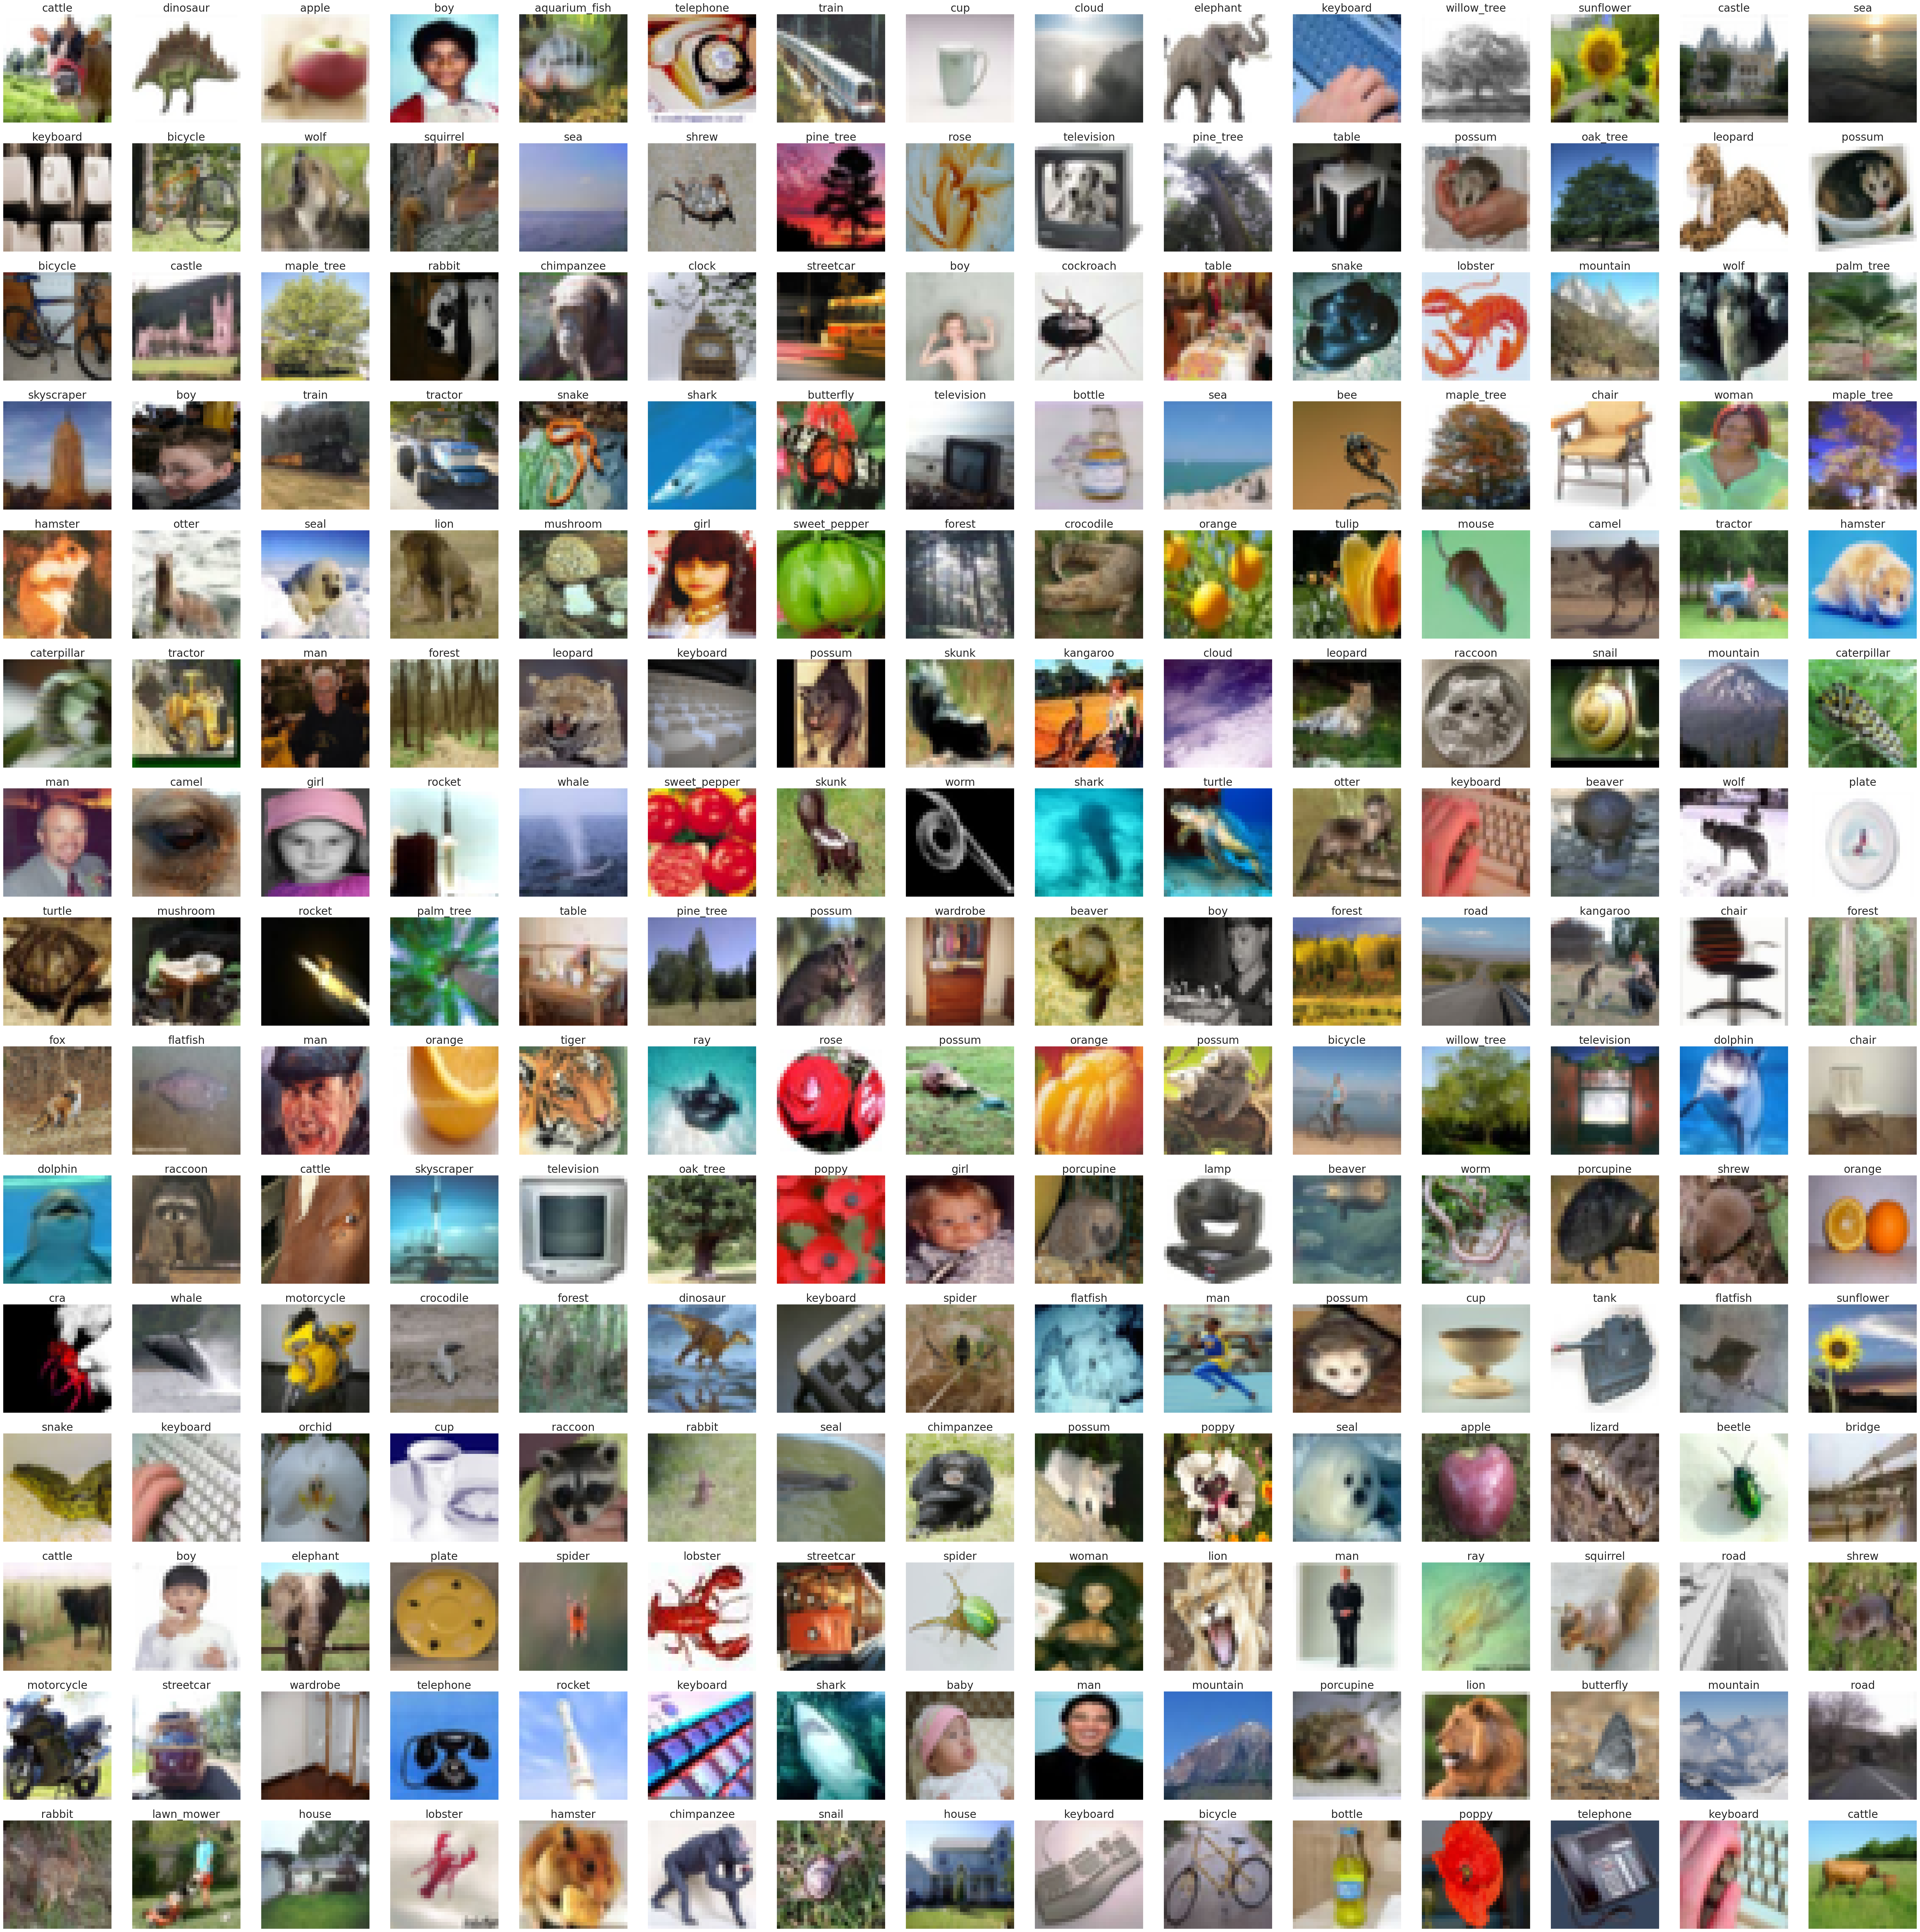

In [19]:
panel_sz = 4
grid_sz = (15, 15)
fig, axes = plt.subplots(nrows=grid_sz[0], ncols=grid_sz[1], figsize=(grid_sz[0]*panel_sz, grid_sz[1]*panel_sz))

for r in range(grid_sz[0]):
    for c in range(grid_sz[1]):
        ind = r*grid_sz[0] + c
        axes[r,c].imshow(x100_train[ind])
        axes[r,c].set_xticks([])
        axes[r,c].set_yticks([])
        axes[r,c].set_title(class100_names[y100_train[ind]])

plt.tight_layout()
plt.show()

### 5b. Train the Inception Net on CIFAR-100

See how well your Inception Net does at classifying CIFAR-100 images! Use same hyperparameters as CIFAR-10.

At the end of training, print out the CIFAR-100 test accuracy.

**Note:**
- Your dataset has 100 classes now, not 10. You will need to make a small update to your network config.
- Because CIFAR-100 has the same number of samples as CIFAR-10 and each color image sample has the same `(32, 32)` spatial resolution, training your InceptionNet on CIFAR-100 should take about the same time as it did on CIFAR-10 :)
- Make sure you are training on the **standardized** CIFAR-100.

In [20]:
x100_train, y100_train, x100_val, y100_val, x100_test, y100_test, class100_names = get_dataset('cifar100')

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)


# YOUR CODE HERE
inception_net = InceptionNet(C=100, input_feats_shape=(32, 32, 3), reg=1.5)
inception_net.compile(optimizer='adamw')
train_loss_hist, val_loss_hist, val_acc_hist, e = inception_net.fit(x100_train, y100_train, x100_val, y100_val, patience=15, lr_patience=4)
print(f'Final val loss: {val_loss_hist[-1]:.4f}, val accuracy: {val_acc_hist[-1]:.4f}')
test_acc, test_loss = inception_net.evaluate(x100_test, y100_test)
print(f'Test loss: {test_loss:.4f}, test accuracy: {test_acc:.4f}')


---------------------------------------------------------------------------
Dense layer output(Output) shape: [1, 100]
Dropout layer output(Dropout) shape: [1, 580]
Global Avg Pooling 2D layer output(GlobalPool) shape: [1, 580]
MaxPool2D layer output(MaxPool3x3_2) shape: [1, 4, 4, 580]
Inception5:
	Conv2D1x1 layer output(Inception5/branch4_1_conv1x1) shape: [1, 8, 8, 128]
	MaxPool2D layer output(Inception5/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D layer output(Inception5/branch3_1_conv5x5) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch3_0_conv1x1) shape: [1, 8, 8, 64]
	Conv2D layer output(Inception5/branch2_1_conv3x3) shape: [1, 8, 8, 196]
	Conv2D1x1 layer output(Inception5/branch2_0_conv1x1) shape: [1, 8, 8, 128]
	Conv2D1x1 layer output(Inception5/branch1_0_conv1x1) shape: [1, 8, 8, 128]
Inception4:
	Conv2D1x1 layer output(Inception4/branch4_1_conv1x1) shape: [1, 8, 8, 64]
	MaxPool2D layer output(Inception4/branch4_0_maxpool3x3) shape: [1, 8, 8, 320]
	Conv2D